In [33]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List

api = wandb.Api()
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5)
sns.set_palette(palette=sns.color_palette())

save_path = Path("/Users/alexanderlontke/Desktop")

In [54]:
def get_run_history(
    api: wandb.Api,
    project_name: str,
    run_name: str,
):
    runs = api.runs(project_name)
    for run in runs:
        if run.name == run_name:
            return run.history()
    return None


def get_run_summary(
    api: wandb.Api,
    project_name: str,
    run_name: str,
):
    runs = api.runs(project_name)
    for run in runs:
        if run.name == run_name:
            return run.summary
    return None


def match_name(name: str, with_frozen: bool = False):
    nl = name.lower()
    frozen_flag = ""
    if "frozen_true" in nl:
        frozen_flag = " Frozen"
    if "simclr" in nl:
        name = "SimCLR"
    elif "vae" in nl:
        name = "VAE"
    elif "bigan" in nl:
        name = "BiGAN"
    elif "random" in nl:
        name = "Random Init"
    else:
        return None
    if with_frozen:
        return name + frozen_flag
    else:
        return name


def visualize_training_trajectory(
    run_history: pd.DataFrame,
    x_key: str = "trainer/global_step",
    y_key: str = "train/NTXentLoss_step",
    y_label: str = "Train NT-Xent Loss",
    x_label: str = "Step",
):
    ax = sns.lineplot(
        data=run_history,
        y=y_key,
        x=x_key,
    )
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

## SimClr Training Trajectory ##

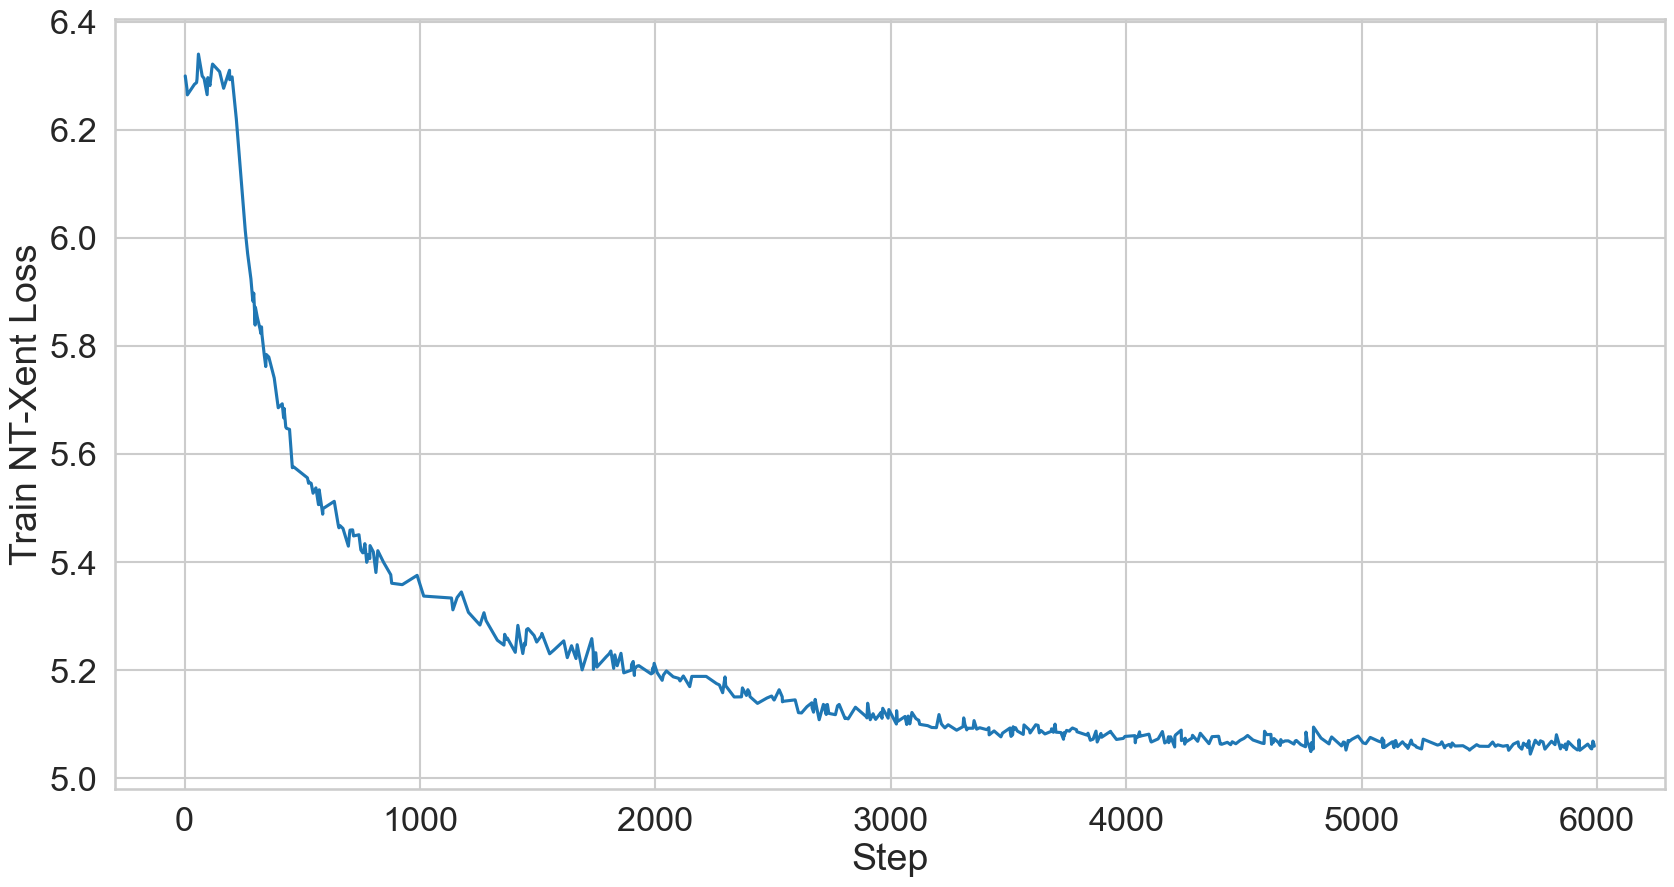

In [6]:
plt.figure(figsize=(20, 10))
simclr_run_history = get_run_history(
    api=api,
    project_name="alontke/ssl-remote-sensing-simclr",
    run_name="splendid-night-40",
)
visualize_training_trajectory(
    run_history=simclr_run_history,
)
plt.savefig(save_path / "simclr_training.png", bbox_inches="tight")

## Classification Downstream Task ##

In [7]:
run_names_of_interest = [
    "SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_True_linear_True",
    "bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_True_linear_True",
    "random_lr_0.001_frozen_True_linear_True",
    "vae_bigearthnet.ckpt_lr_0.001_frozen_True_linear_True",
    "SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_True_linear_False",
    "bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_True_linear_False",
    "random_lr_0.001_frozen_True_linear_False",
    "vae_bigearthnet.ckpt_lr_0.001_frozen_True_linear_False",
    "SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_False_linear_True",
    "bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_False_linear_True",
    "random_lr_0.001_frozen_False_linear_True",
    "vae_bigearthnet.ckpt_lr_0.001_frozen_False_linear_True",
    "SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt_lr_0.001_frozen_False_linear_False",
    "bigan_encoder_allChannels_10_epochs.ckpt_lr_0.001_frozen_False_linear_False",
    "random_lr_0.001_frozen_False_linear_False",
    "vae_bigearthnet.ckpt_lr_0.001_frozen_False_linear_False",
]

## Training Trajectories ##

In [8]:
def plot_classification_training_trajectories(
    run_names_of_interest,
    run_name_infix: Optional[str] = None,
    aggregate: str = "_step",
):
    run_name_key = "run_name"
    classification_run_histories = []
    for run_name in run_names_of_interest:
        if not run_name_infix or run_name_infix in run_name:
            current_history = get_run_history(
                api=api,
                project_name="alontke/ssl-remote-sensing-classification",
                run_name=run_name,
            )
            if current_history is None:
                print(run_name)
            current_history[run_name_key] = run_name
            classification_run_histories += [current_history]
    all_histories = pd.concat(classification_run_histories)
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))

    pivot_table = all_histories.pivot(
        index=aggregate, columns=run_name_key, values="step/training_loss"
    )
    for column in pivot_table.columns:
        sns.lineplot(
            data=pivot_table[column],
            ax=ax,
            label=match_name(column),
        )
    if aggregate == "_step":
        ax.set_xlabel("Step")
    elif aggregate == "_timestamp":
        ax.set_xlabel("Timestamp")
    ax.set_ylabel("Cross Entropy Loss")
    # ax.set_title(f"Training Trajectories (Infix: {infix})")

## Classification Accuracies ##

In [9]:
def plot_classification_accuracy(
    run_names_of_interest, run_name_infix: Optional[str] = None
):
    plt.figure(figsize=(20, 15))
    run_name_to_viz = "Run Name"
    metric_to_viz = "Accuracy"
    metrics = {
        metric_to_viz: [],
        run_name_to_viz: [],
    }
    for run_name in run_names_of_interest:
        if not run_name_infix or run_name_infix in run_name:
            current_metric = get_run_summary(
                api=api,
                project_name="alontke/ssl-remote-sensing-classification",
                run_name=run_name,
            )["classification_report"]["accuracy"]
            metrics[run_name_to_viz] += [match_name(run_name)]
            metrics[metric_to_viz] += [current_metric]
    print(metrics)
    ax = sns.barplot(data=metrics, x=run_name_to_viz, y=metric_to_viz)
    # ax.set_title(f"Accuracy (Infix: {infix})")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Pre-Text Task")

## Frozen: True, Linear: True ##

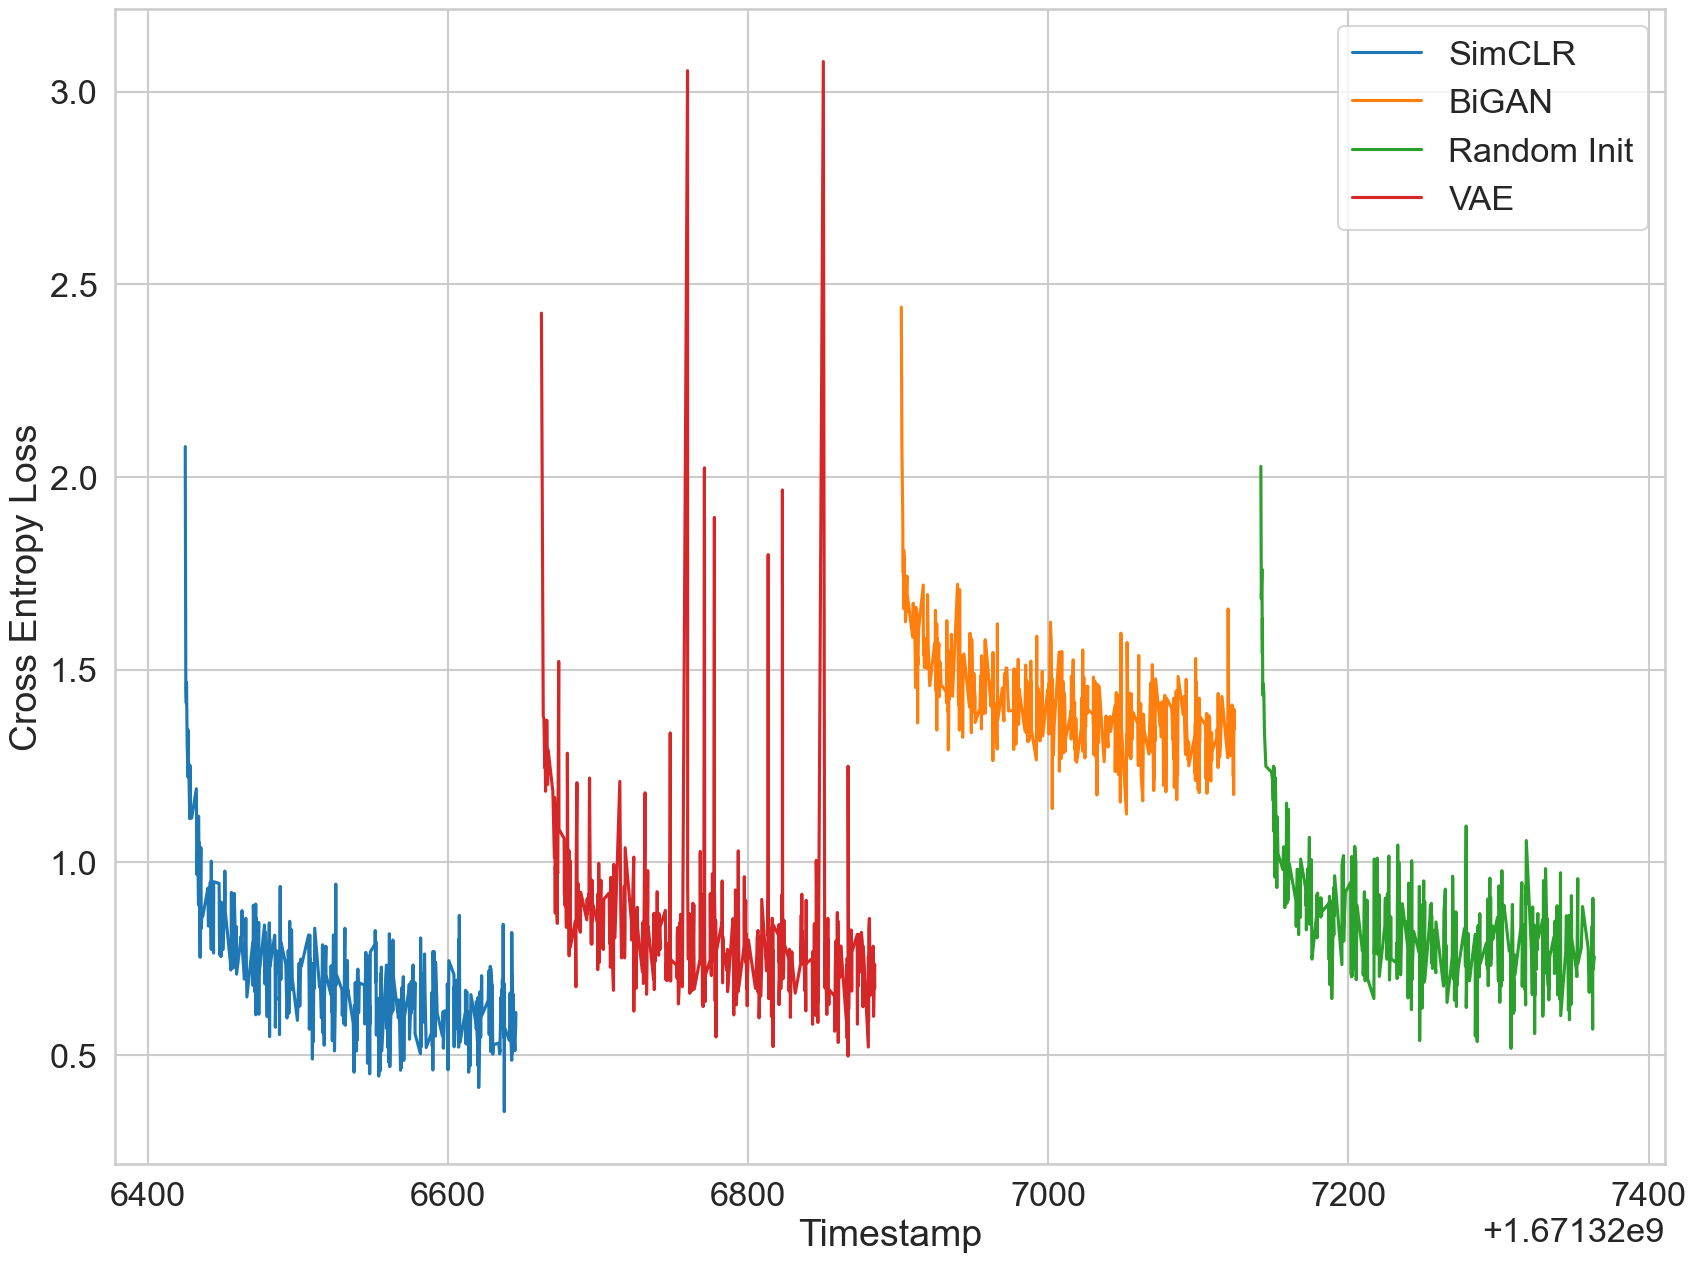

In [10]:
infix = "frozen_True_linear_True"
plot_classification_training_trajectories(
    run_names_of_interest, run_name_infix=infix, aggregate="_timestamp"
)
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

{'Accuracy': [0.7674074074074074, 0.5053703703703704, 0.6675925925925926, 0.7281481481481481], 'Run Name': ['SimCLR', 'BiGAN', 'Random Init', 'VAE']}


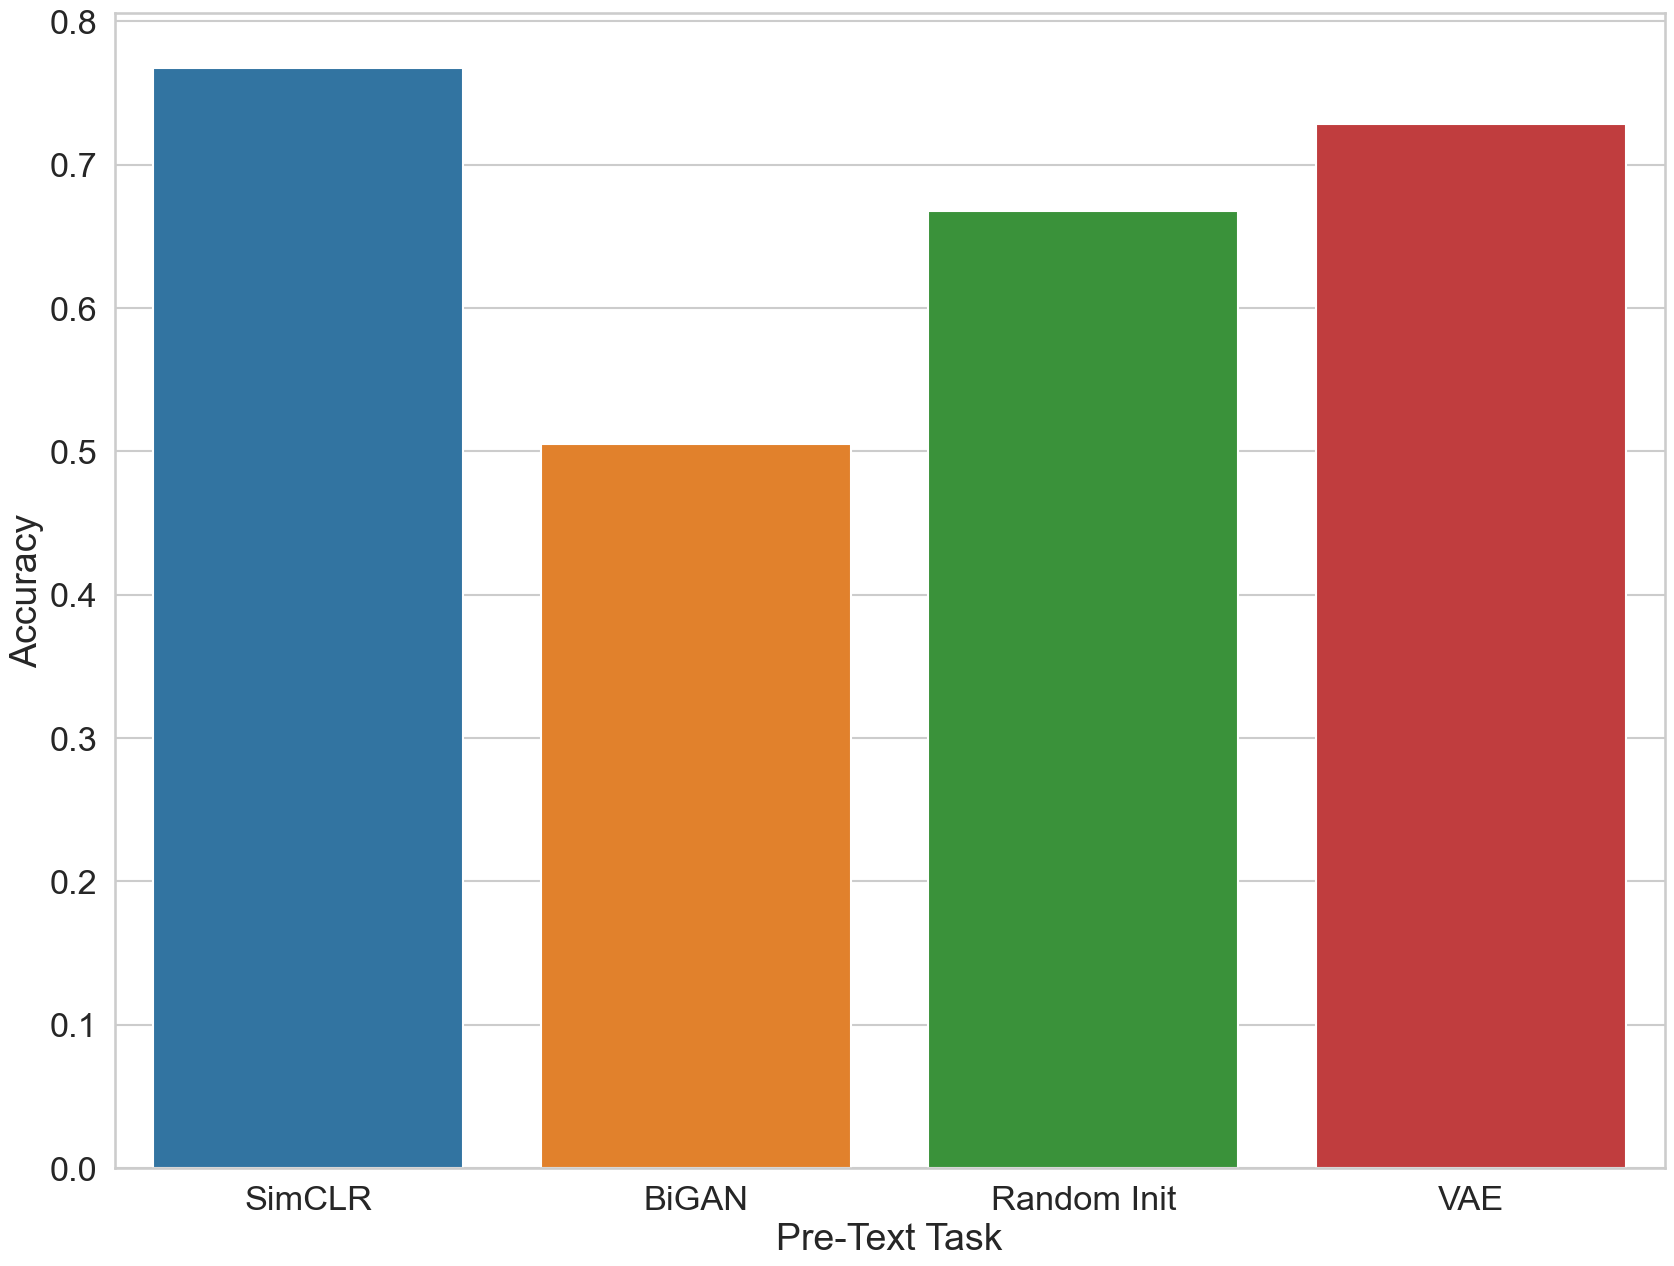

In [11]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: False, Linear: True ##

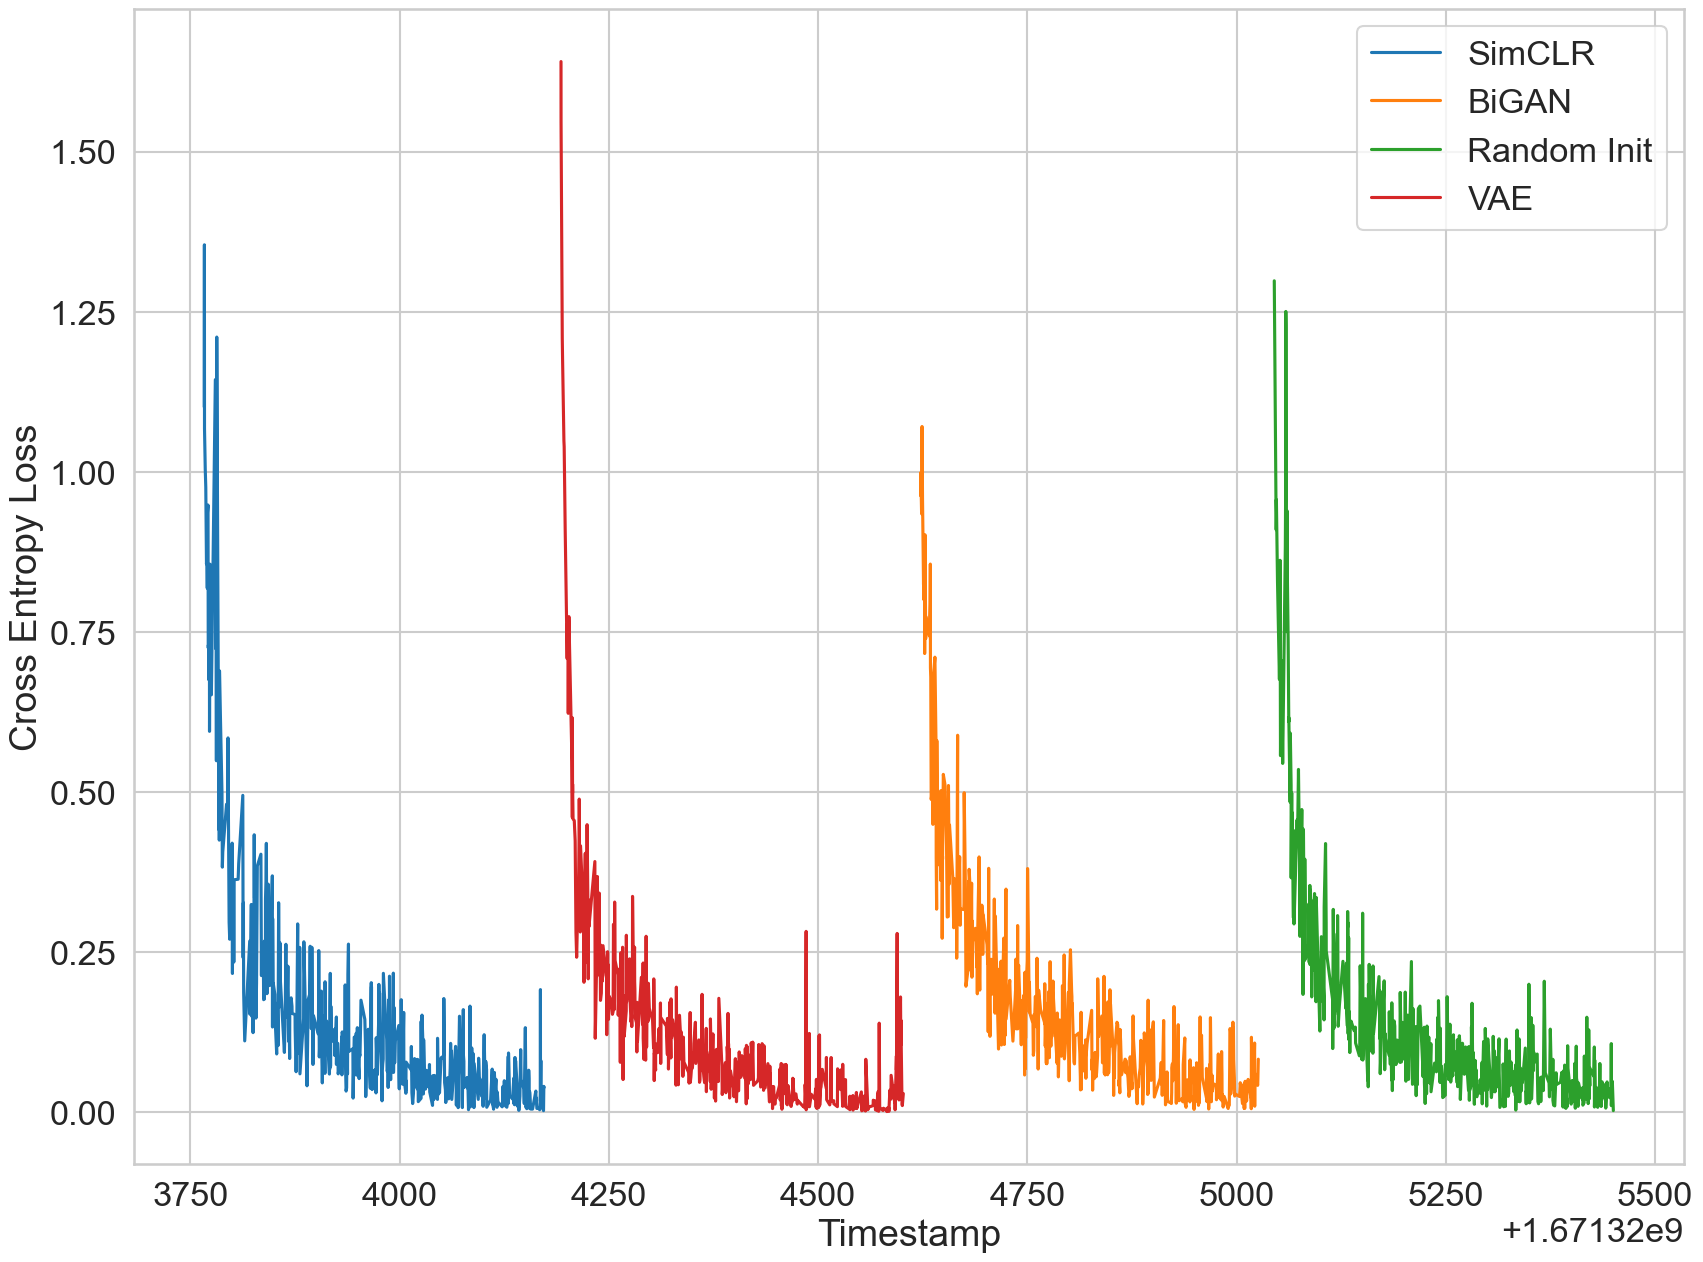

In [12]:
infix = "frozen_False_linear_True"
plot_classification_training_trajectories(
    run_names_of_interest, run_name_infix=infix, aggregate="_timestamp"
)
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

{'Accuracy': [0.9511111111111112, 0.9351851851851852, 0.9598148148148148, 0.9368518518518518], 'Run Name': ['SimCLR', 'BiGAN', 'Random Init', 'VAE']}


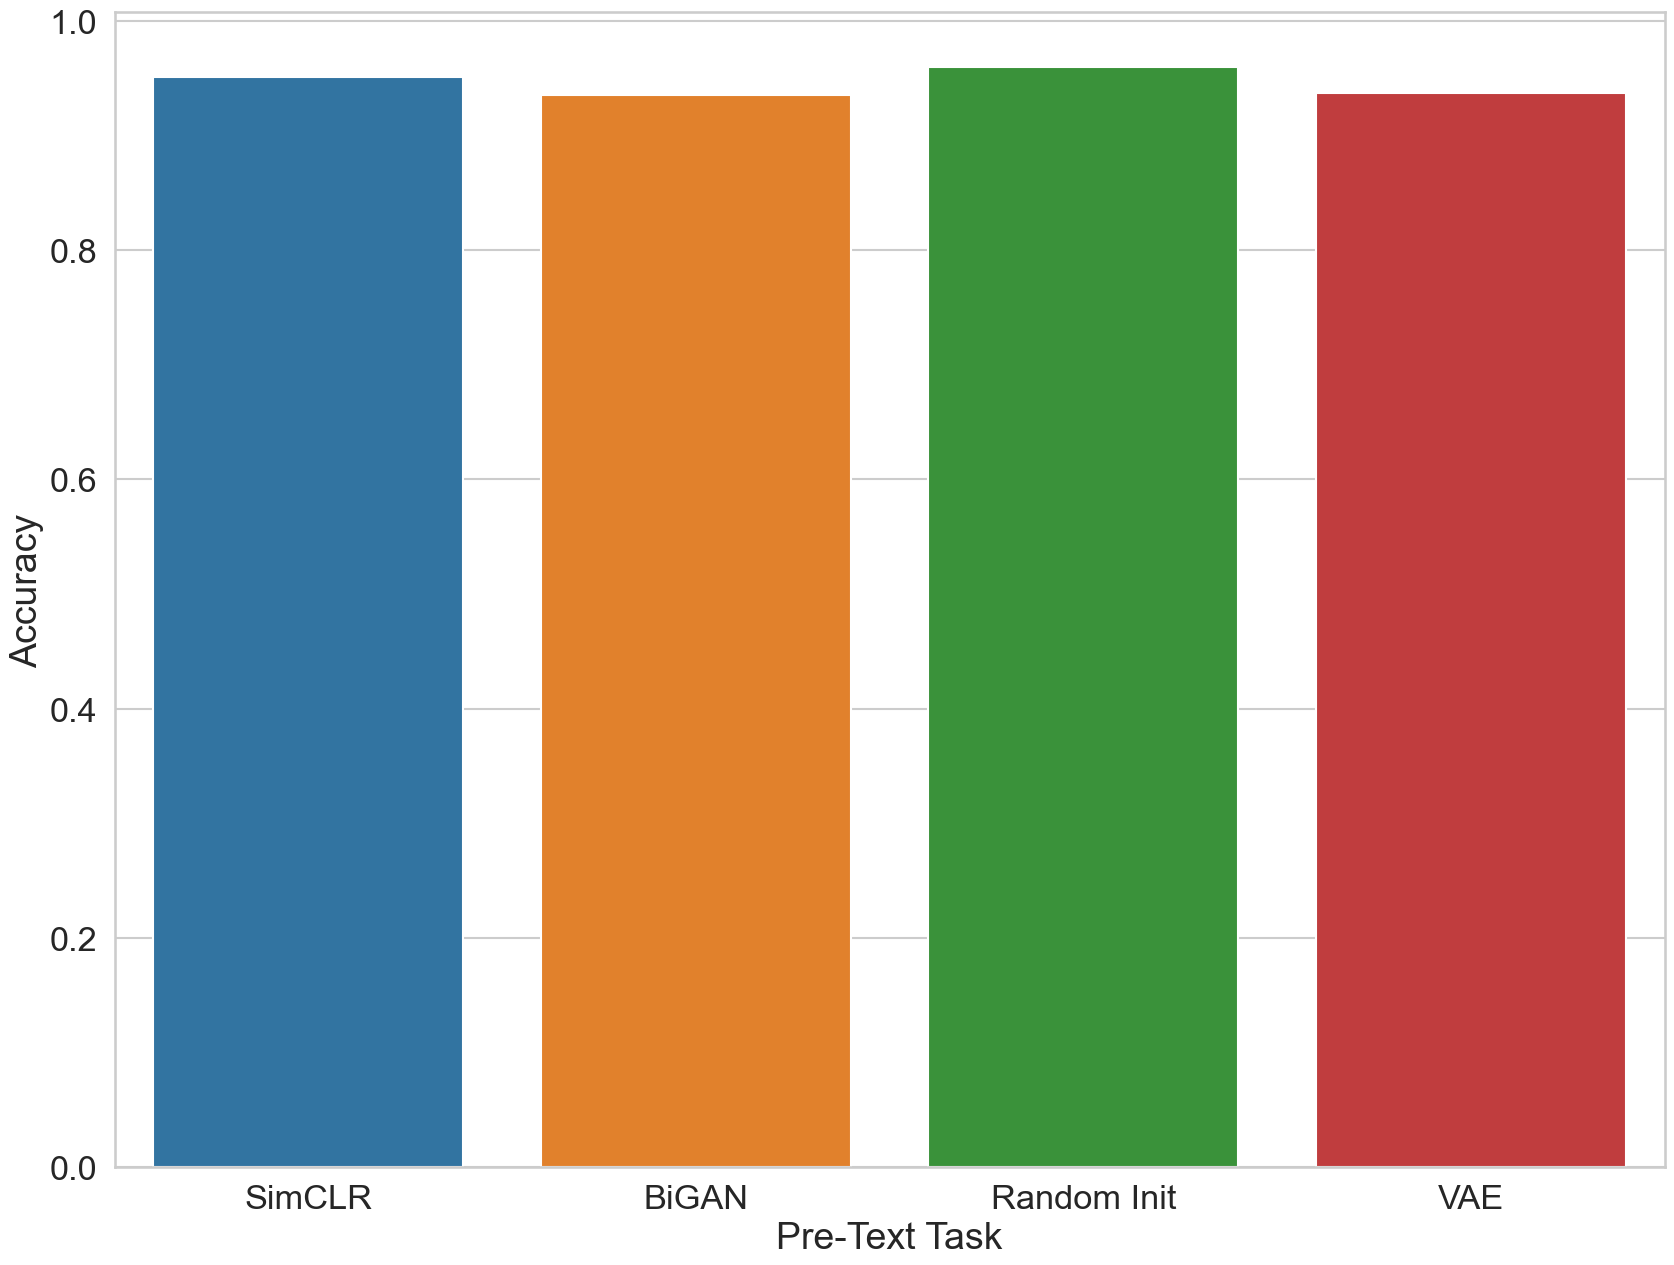

In [13]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: True, Linear: False ##

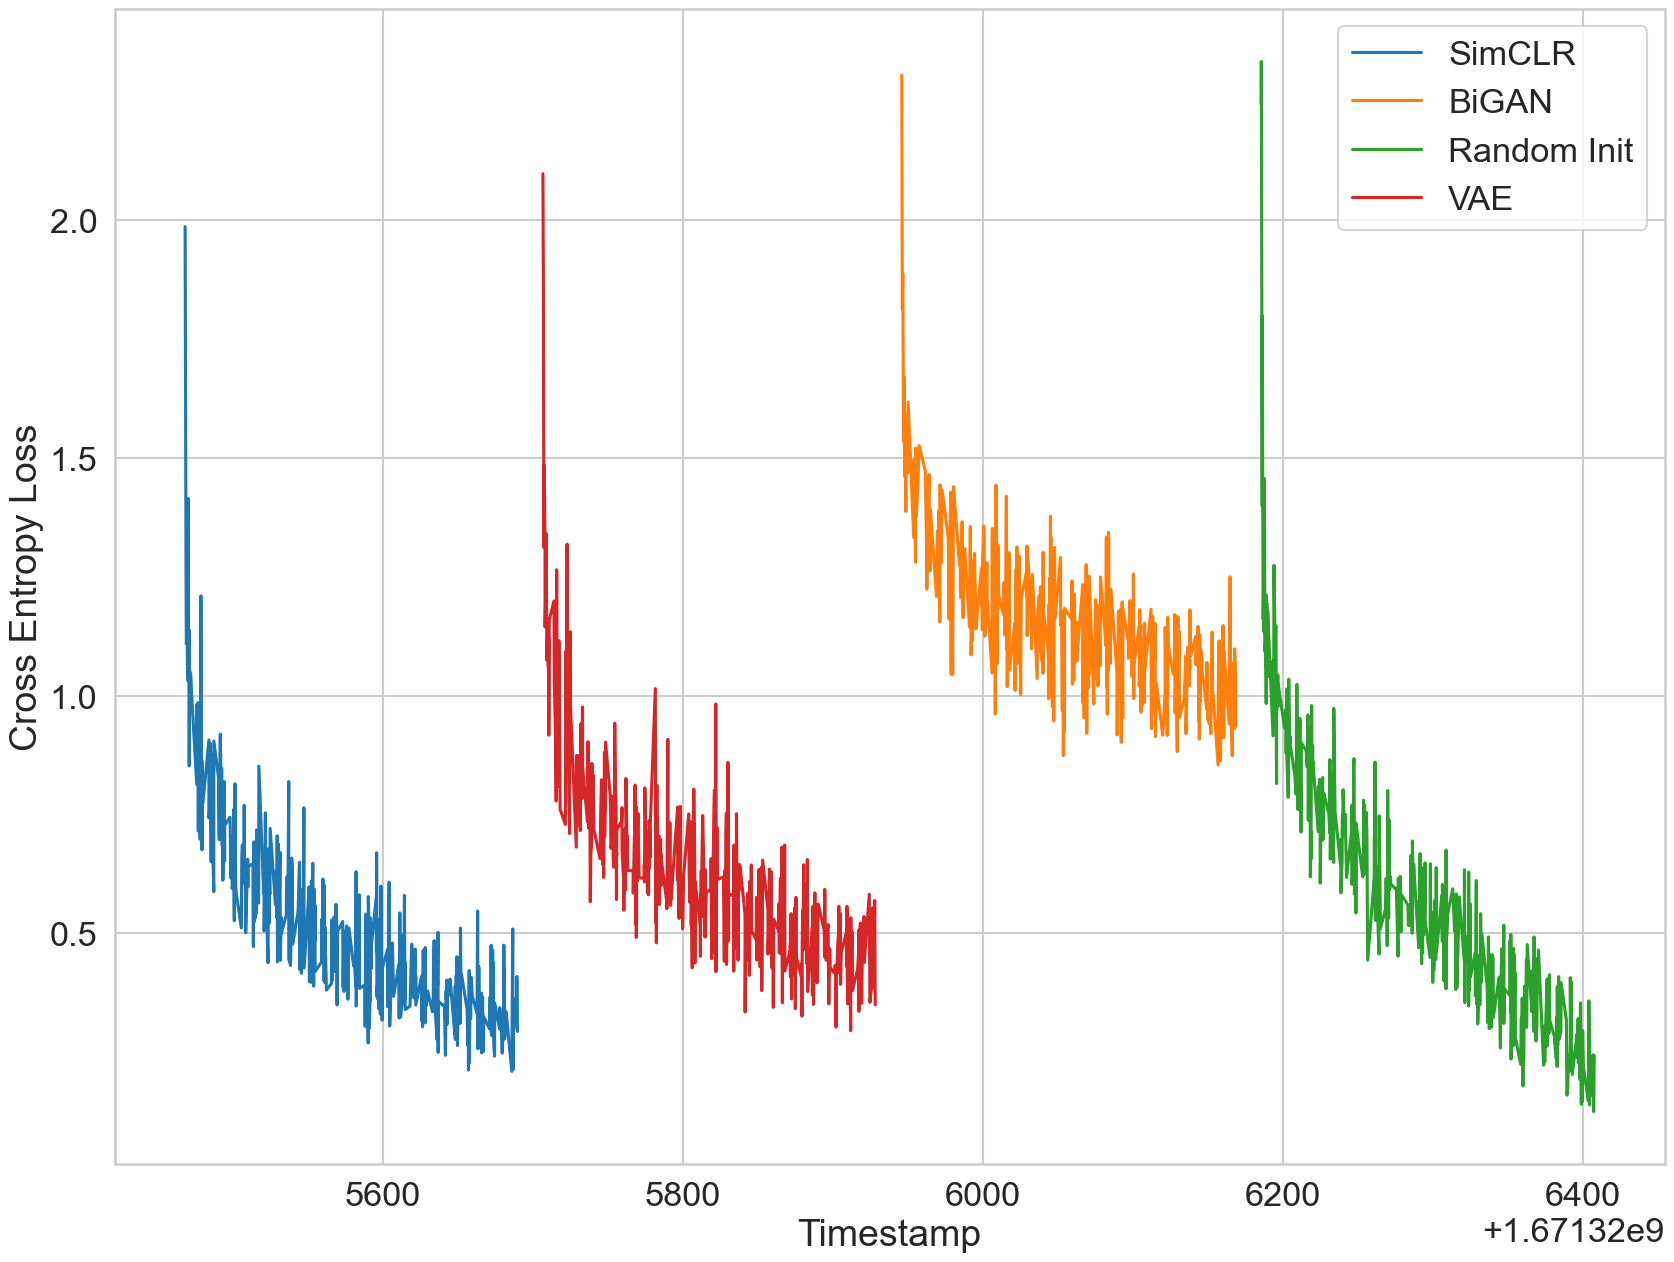

In [14]:
infix = "frozen_True_linear_False"
plot_classification_training_trajectories(
    run_names_of_interest, run_name_infix=infix, aggregate="_timestamp"
)
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

{'Accuracy': [0.8214814814814815, 0.5887037037037037, 0.7155555555555555, 0.7972222222222223], 'Run Name': ['SimCLR', 'BiGAN', 'Random Init', 'VAE']}


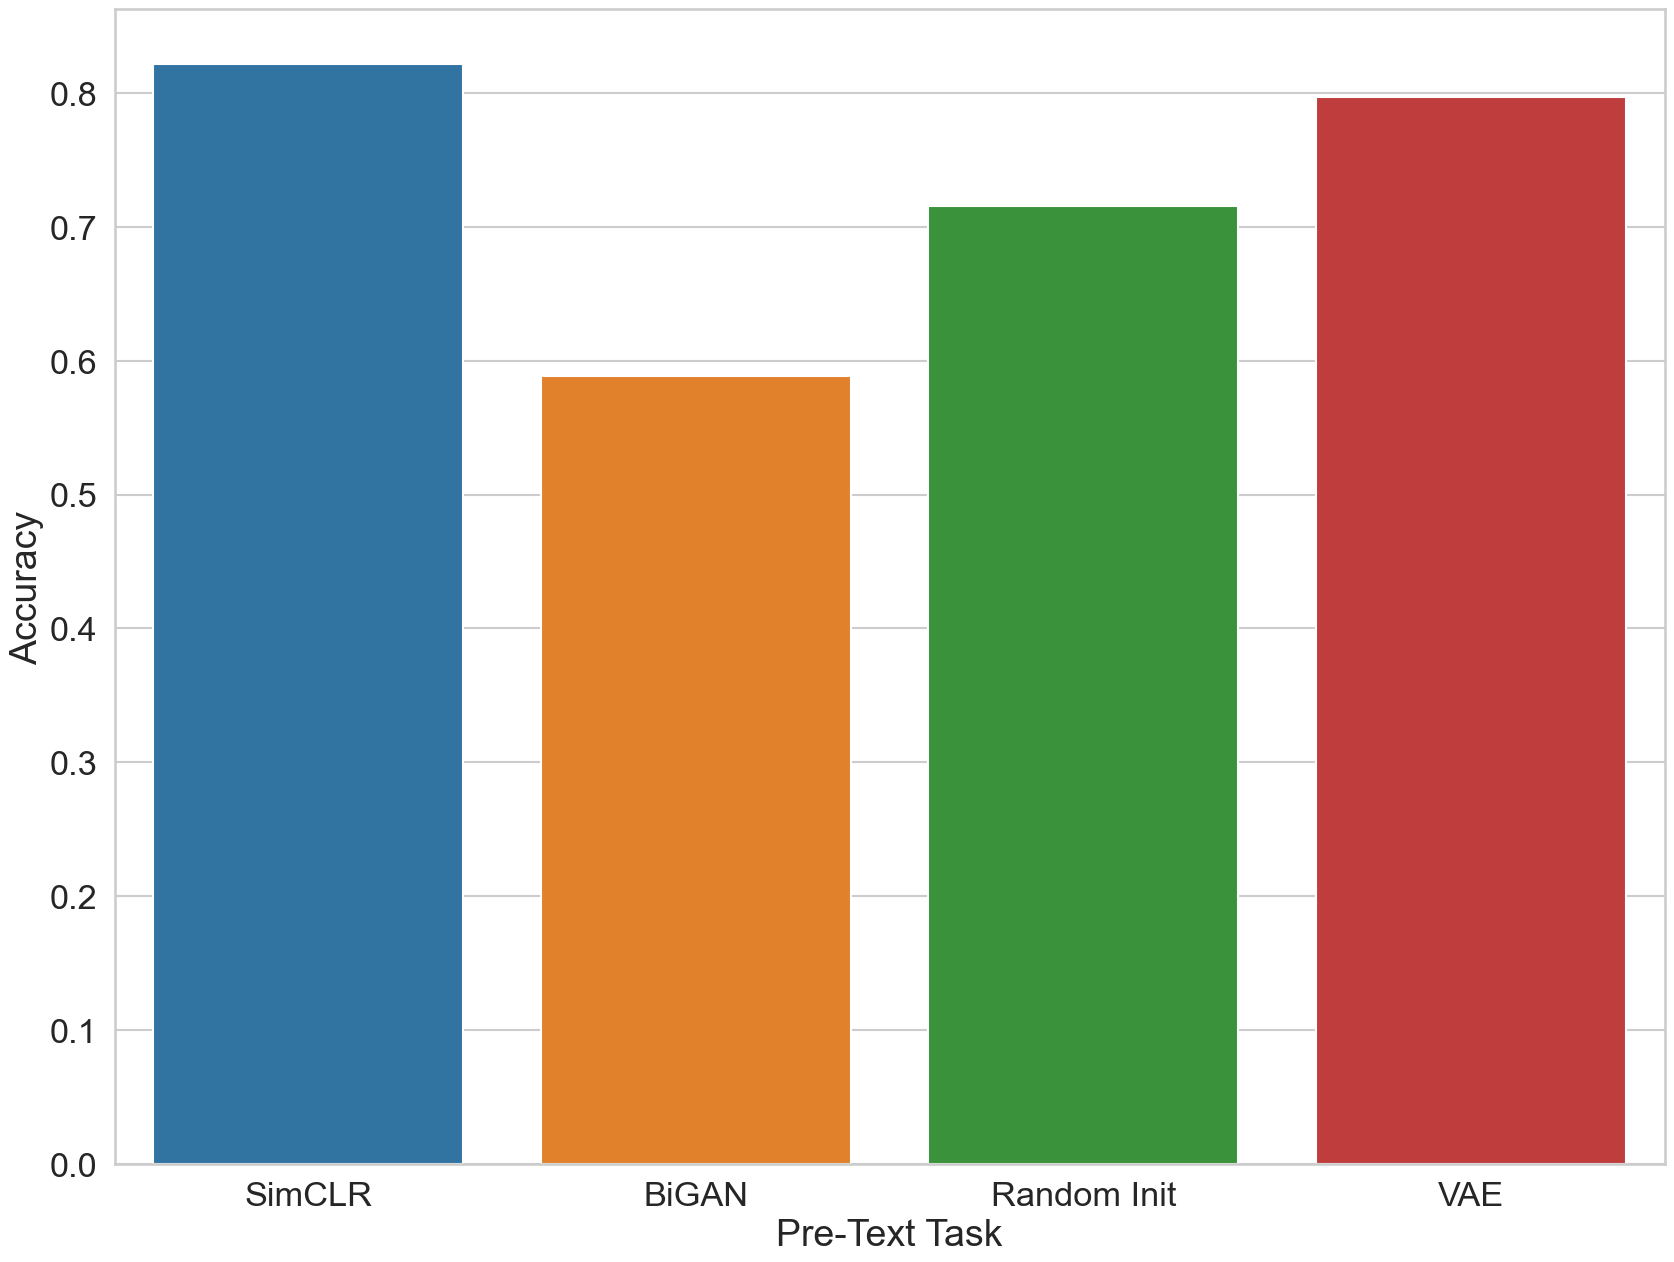

In [15]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Frozen: False, Linear: False ##

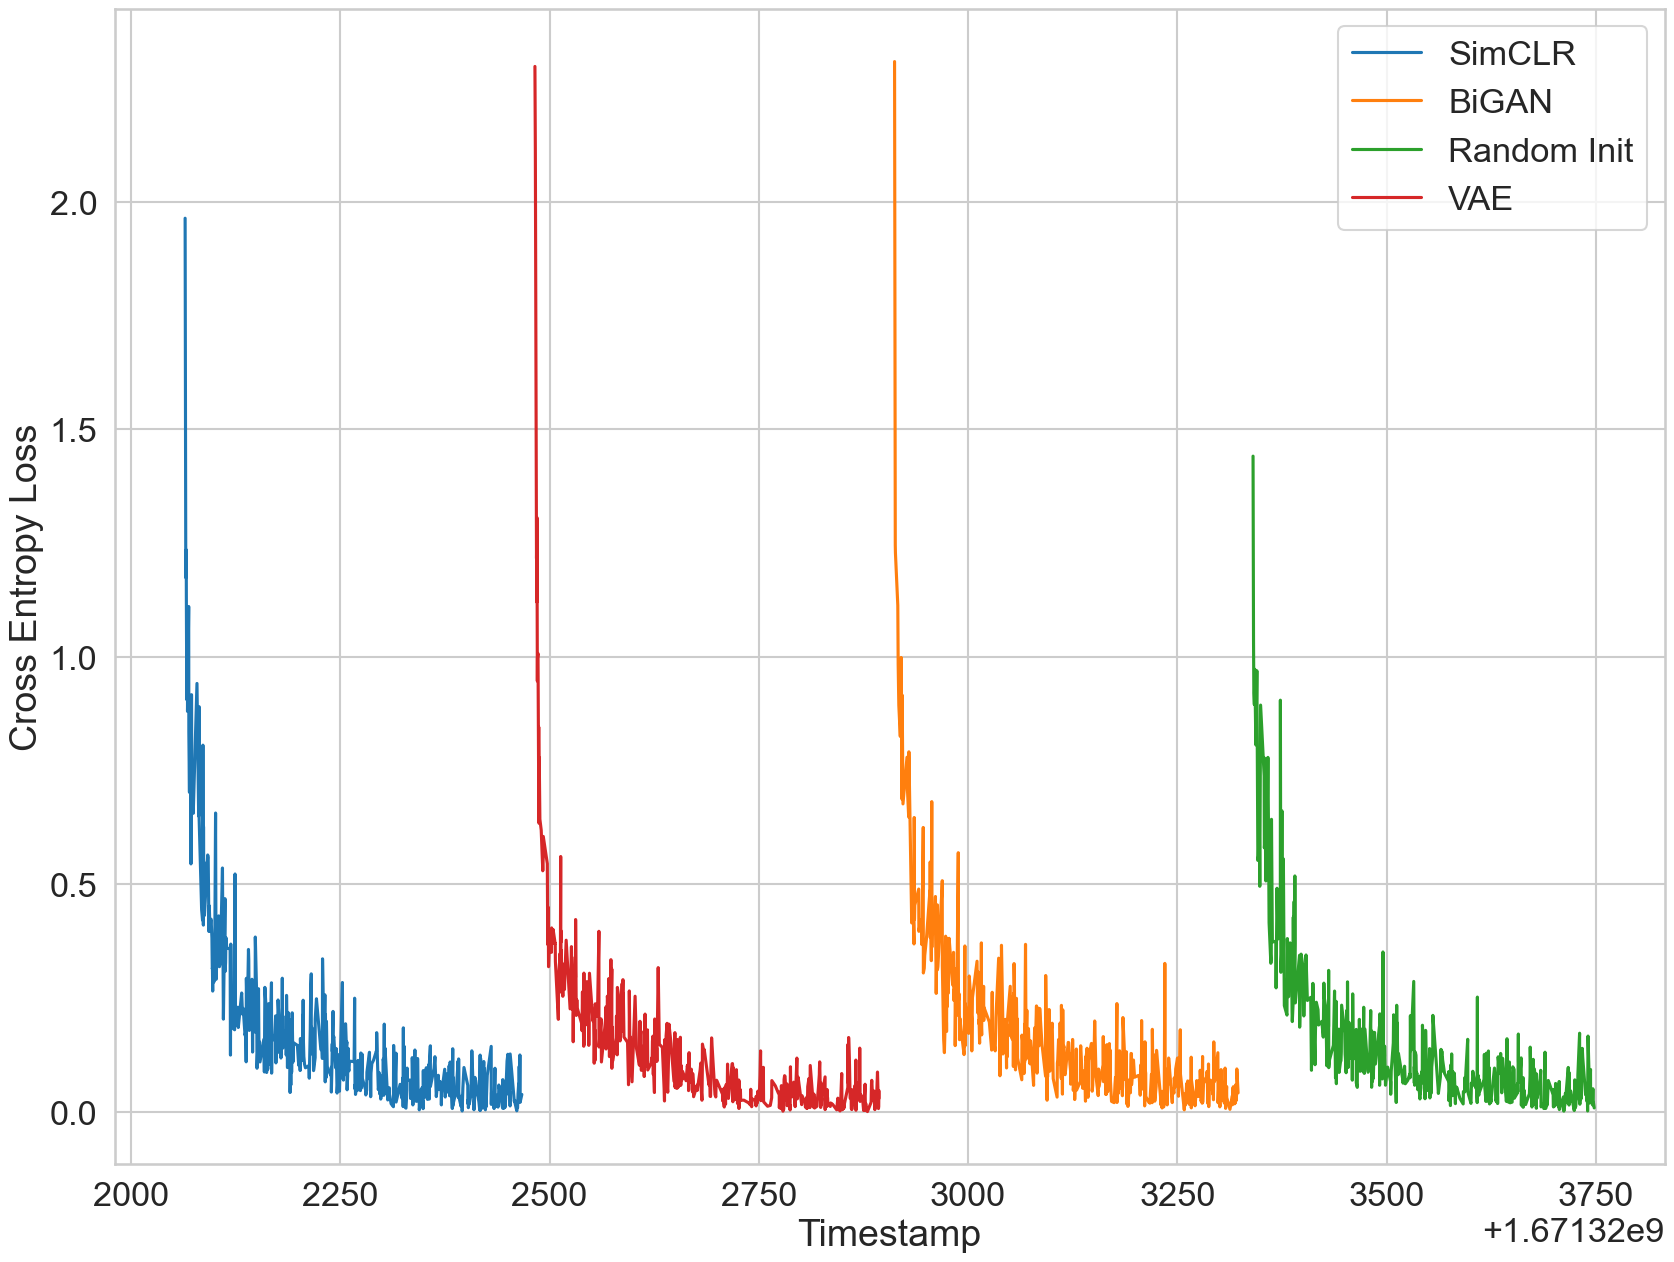

In [16]:
infix = "frozen_False_linear_False"
plot_classification_training_trajectories(
    run_names_of_interest, run_name_infix=infix, aggregate="_timestamp"
)
plt.savefig(save_path / f"Training Trajectories (Infix: {infix})")

{'Accuracy': [0.9412962962962964, 0.9322222222222222, 0.9424074074074074, 0.925925925925926], 'Run Name': ['SimCLR', 'BiGAN', 'Random Init', 'VAE']}


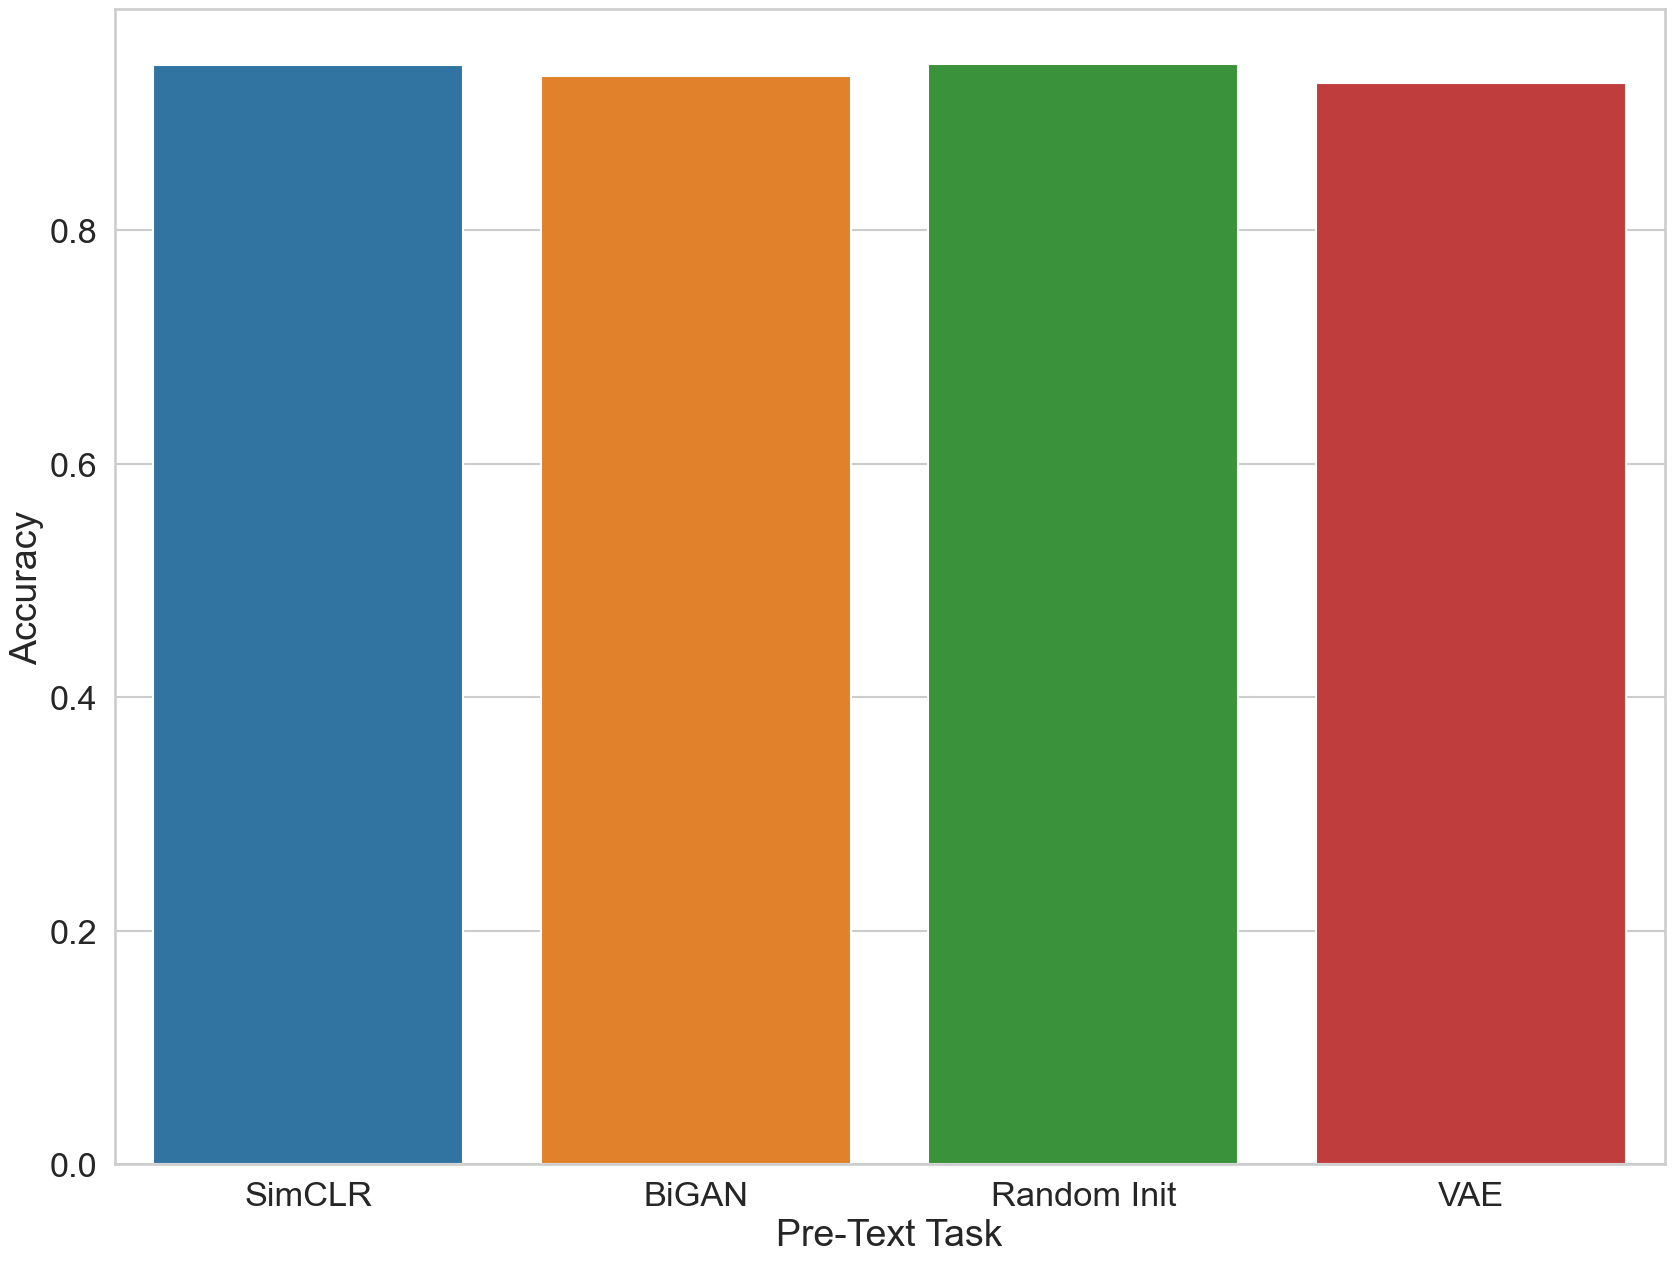

In [17]:
plot_classification_accuracy(
    run_names_of_interest=run_names_of_interest,
    run_name_infix=infix,
)
plt.savefig(save_path / f"Accuracies (Infix: {infix})")

## Dataset Subsampling ##

In [18]:
def get_all_run_summaries(
    api: wandb.Api,
    project_name: str,
):
    runs = api.runs(project_name)
    run_summaries = {}
    for run in runs:
        run_summaries[run.name] = run.summary
    return run_summaries

In [ ]:
all_summaries = get_all_run_summaries(
    api, project_name="ssl-remote-sensing-classification-label-fraction-experiment"
)

In [ ]:
def dataset_subsample_plot(summaries):
    dataset_sizes = [216, 2160, 10800, 21600]
    x_key = "Dataset Size"
    y_key = "Accuracy"
    run_name_key = "Run name"
    to_viz = {x_key: [], y_key: [], run_name_key: []}
    for k, v in summaries.items():
        for ds in dataset_sizes:
            if k.split("_")[-1] == str(ds):
                to_viz[x_key] += [ds]
                to_viz[run_name_key] += [match_name(k)]
                to_viz[y_key] += [v["classification_report"]["accuracy"]]
    plt.figure(figsize=(20, 15))
    ax = sns.lineplot(
        data=to_viz,
        y=y_key,
        x=x_key,
        style=run_name_key,
        hue=run_name_key,
        markers=True,
        linewidth=6,
    )
    plt.legend(loc="lower right")

In [ ]:
dataset_subsample_plot({k: v for k, v in all_summaries.items() if "frozen_False" in k})
plt.savefig(save_path / "Fine_tuned_runs_limited_samples")

In [ ]:
dataset_subsample_plot({k: v for k, v in all_summaries.items() if "frozen_True" in k})
plt.savefig(save_path / "Frozen_runs_limited_samples")

## Dataset Subsampling Table ##

In [40]:
def get_all_run_histories(
    api: wandb.Api,
    project_name: str,
):
    runs = api.runs(project_name)
    run_histories = {}
    for run in runs:
        run_histories[run.name] = run.history()
    return run_histories

In [106]:
def dataset_subsample_plot(histories, agg_func:str = "max"):
    dataset_sizes = [216, 2160, 10800, 21600]
    x_key = "Dataset Size"
    y_key = "Accuracy"
    run_name_key = "Run name"
    to_viz = {x_key: [], y_key: [], run_name_key: []}
    for k, v in histories.items():
        for ds in dataset_sizes:
            if k.split("_")[-1] == str(ds):
                to_viz[x_key] += [ds]
                to_viz[run_name_key] += [match_name(k, with_frozen=True)]
                to_viz[y_key] += [getattr(v["epoch/classification_report.accuracy"], agg_func)()]
    plt.figure(figsize=(20, 15))
    ax = sns.lineplot(
        data=to_viz,
        y=y_key,
        x=x_key,
        style=run_name_key,
        hue=run_name_key,
        markers=True,
        linewidth=6,
    )
    plt.legend(loc="lower right")

In [46]:
all_histories = get_all_run_histories(
    api, project_name="ssl-remote-sensing-classification-label-fraction-experiment"
)

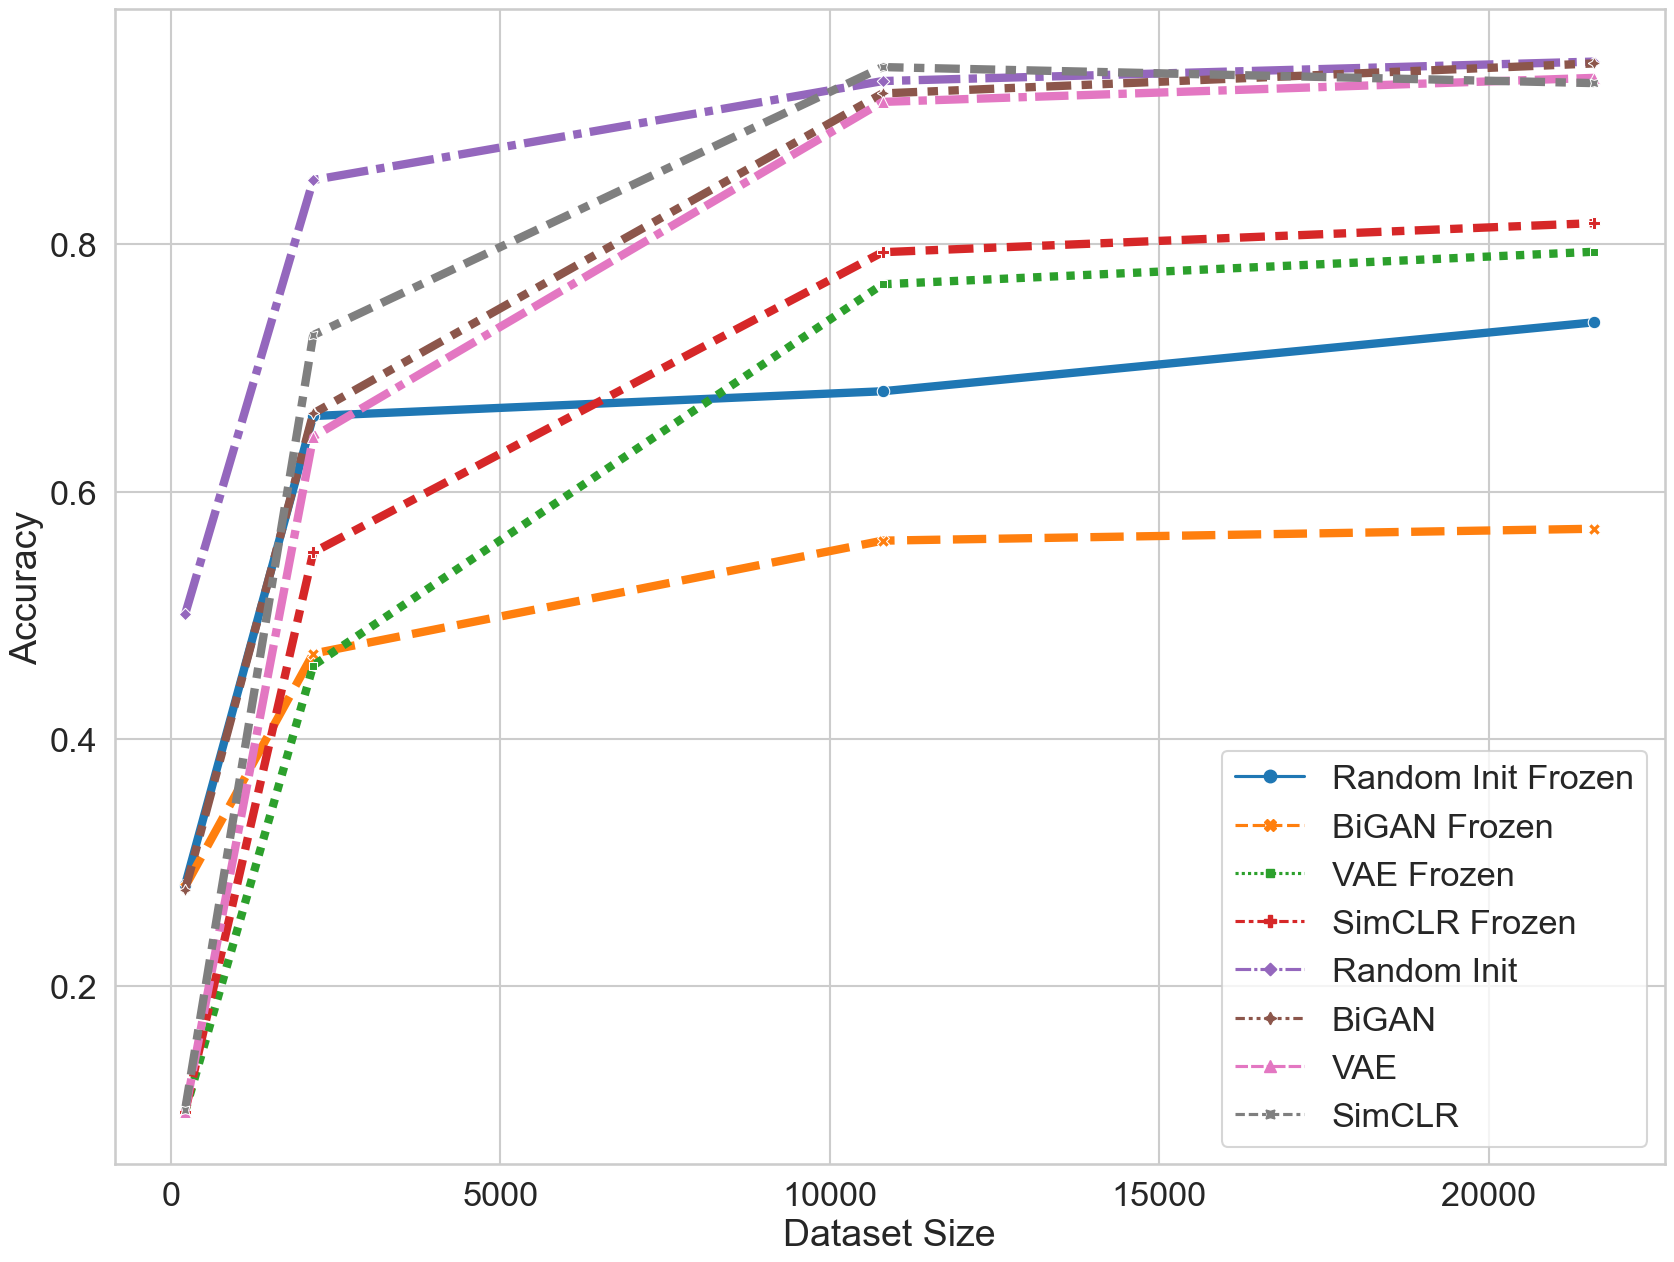

In [107]:
dataset_subsample_plot(
    all_histories
)

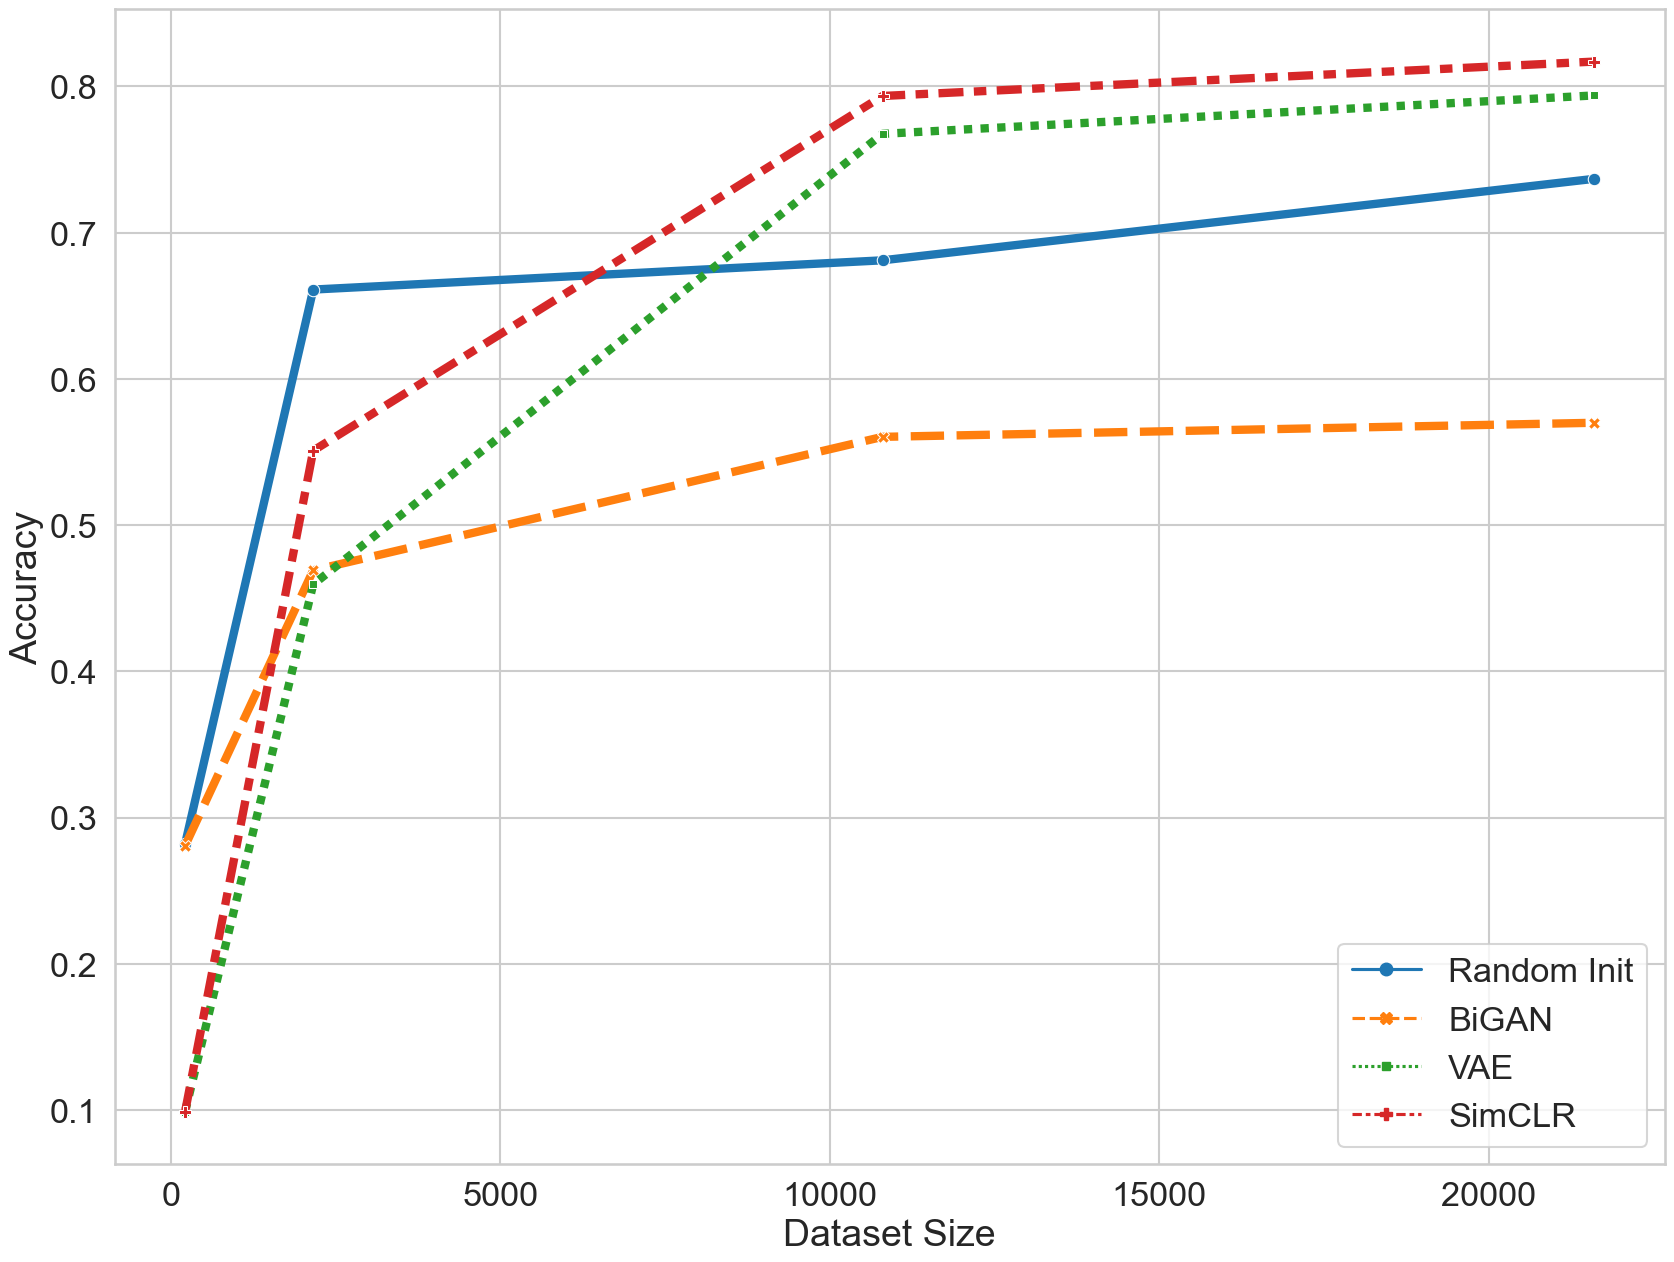

In [62]:
dataset_subsample_plot(
   {k: v for k, v in all_histories.items() if "frozen_True" in k}, agg_func="max"
)

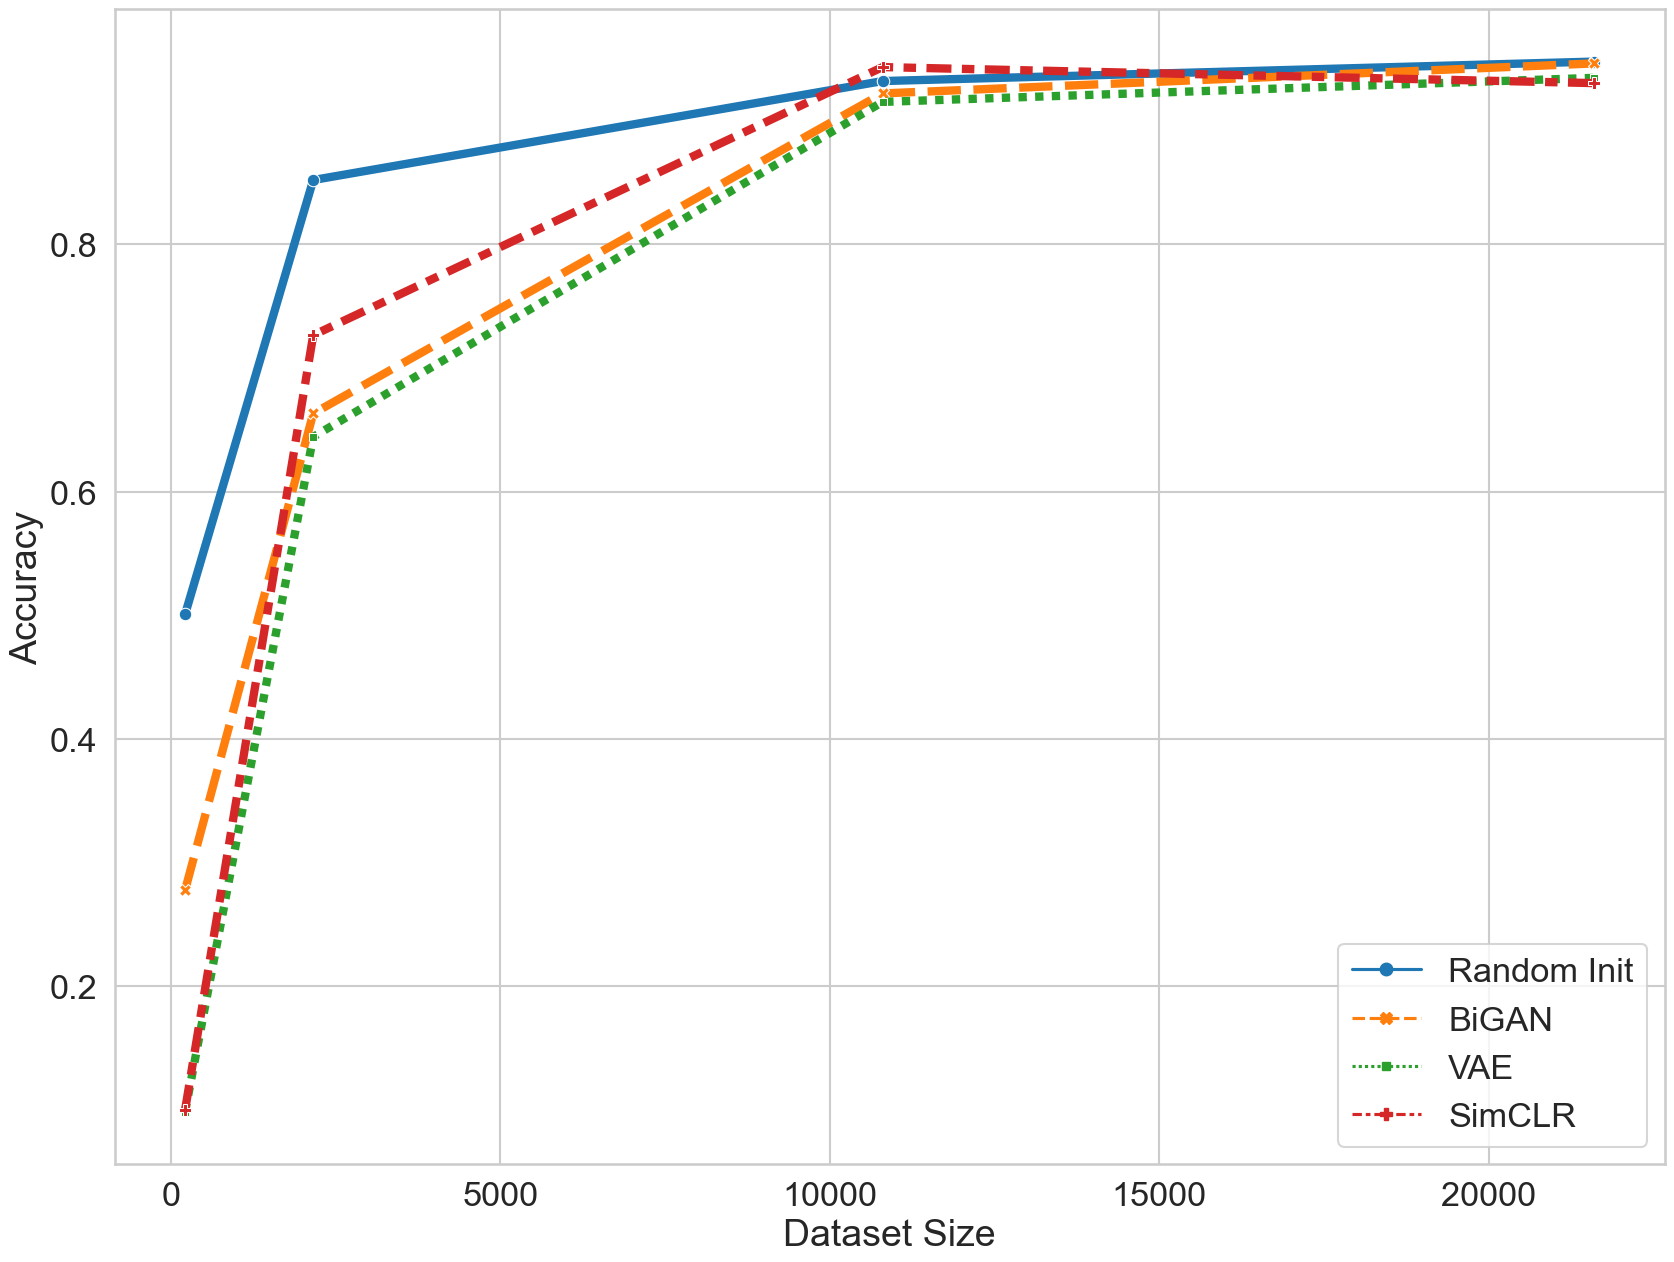

In [59]:
dataset_subsample_plot(
   {k: v for k, v in all_histories.items() if "frozen_False" in k}
)

In [74]:
def get_table_data(all_histories, linear: bool):
    all_histories = {k: v for k, v in all_histories.items() if f"linear_{linear}" in k}
    frozen_histories = {k: v for k, v in all_histories.items() if "frozen_True" in k}
    fine_tuned_histories = {k: v for k, v in all_histories.items() if "frozen_False" in k}
    results = {
        match_name(k): {}
        for k, _ in all_histories.items()
    }
    for k, v in frozen_histories.items():
        results[match_name(k)][k.split("_")[-1]] = {"Frozen": v["epoch/classification_report.accuracy"].max()}
    for k, v in fine_tuned_histories.items():
        results[match_name(k)][k.split("_")[-1]]["Fine-Tuned"] = v["epoch/classification_report.accuracy"].max()
    return results

In [77]:
table_data = get_table_data(all_histories, False)

In [104]:
table = ""
seperator = "\t"
cell_seperator = "&"
for k in ["SimCLR", "VAE", "BiGAN", "Random Init"]:
    v = table_data[k]
    entry_line = "\multicolumn{3}{|l|}{" + k + "}"
    entry_line += seperator
    for k1 in ["216", "2160", "10800", "21600"]:
        v1 = v[k1]
        for key in ["Frozen", "Fine-Tuned"]:
            entry_line += cell_seperator + seperator + v1[key].__format__(".2f") + seperator
    entry_line += "\\\\ \hline \n"
    table += entry_line

In [105]:
print(table)

\multicolumn{3}{|l|}{SimCLR}	&	0.10	&	0.10	&	0.55	&	0.73	&	0.79	&	0.94	&	0.82	&	0.93	\\ \hline 
\multicolumn{3}{|l|}{VAE}	&	0.10	&	0.10	&	0.46	&	0.64	&	0.77	&	0.92	&	0.79	&	0.93	\\ \hline 
\multicolumn{3}{|l|}{BiGAN}	&	0.28	&	0.28	&	0.47	&	0.66	&	0.56	&	0.92	&	0.57	&	0.95	\\ \hline 
\multicolumn{3}{|l|}{Random Init}	&	0.28	&	0.50	&	0.66	&	0.85	&	0.68	&	0.93	&	0.74	&	0.95	\\ \hline 

